In [183]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import mutual_info_regression
from datetime import datetime

In [184]:
# connexion a la base de donnees
conn = sqlite3.connect('../Datas/db/fraude_detection_warehouse_.db')

In [185]:
# Extraction des tables
alert = pd.read_sql_query("SELECT * FROM alerts", conn)
customers = pd.read_sql_query("SELECT * FROM customers", conn)
devices = pd.read_sql_query("SELECT * FROM devices", conn)
transaction_history = pd.read_sql_query("SELECT * FROM transaction_history", conn)
transaction_patterns= pd.read_sql_query("SELECT * FROM transaction_patterns", conn)
transactions = pd.read_sql_query("SELECT * FROM transactions", conn)

alert.head()


,alert_id,transaction_id,alert_date,alert_type,alert_status,description
0,51a83841-582a-49f0-b1b7-534b593f02d8,19a371c6131c4fadaaa4b59555d41927,2022-04-25 03:40:24,large transaction,closed,Woman life might health ever statement range.\...
1,3eb26fef-a1cf-49e2-ba05-23c0c72a4f7f,5462c26c89794e108f33acd5a6aba434,2020-05-08 18:50:52,large transaction,open,Both his benefit especially development wester...
2,b9103754-365e-42c6-a263-3cd296504dcd,8ad7f3906e4d410988894e9983e21cad,2021-09-10 03:36:03,large transaction,closed,Structure night election civil old. White boy ...
3,5df28a26-9f75-40bc-82a2-a2a43da4f3b8,b9504927c22846babb4943e2597f11c9,2022-04-02 08:03:32,suspicious activity,closed,White big create light blood commercial countr...
4,acc68d65-0fea-4541-a7aa-e0982fdfd4fe,1fc48491d2724c8fb2c3d7ab08c339c8,2024-02-22 10:38:47,large transaction,open,Look her cost. Later which black computer.\nLi...


In [186]:
# Fusion des tables
df1 = transactions.merge(customers, on='customer_id', how='left').drop(columns=['first_name', 'last_name', 'transaction_date'])
df2 = df1.merge(devices, on='device_id', how='left')
df3 = df2.merge(transaction_history, on=['customer_id', 'transaction_id'], how='left')

df3.head()

,transaction_id,customer_id,device_id,transaction_type,amount,status,is_fraud,location,email,phone_number,...,region,device_type,os,manufacturer,model,last_used,history_id,previous_balance,new_balance,transaction_date
0,731b17cfadce442ab756b5b110a406c2,d159ae25b3d04387bbc006b8f0df4629,f66d0310-bf70-4552-a732-5950c93b1134,depôt,9.385805e+06,réussie,1,Douala,Kim.Nguyen@lopez-wolfe.com,+237 656344405,...,Centre,tablette,linux,LG,envy45,2023-12-01 16:08:02,1e9c3c0fc0b1496d8d2901d0f8f3531d,1.933918e+07,2.872498e+07,2020-02-12
1,96f4ac611eaa4174b39149d98e569810,84d0894d1b9a4a8dbe13cfbb32d451df,f765ead3-ca24-48f4-9252-a6fd5fc53518,depôt,3.358191e+06,réussie,0,Bafoussam,Gregory.Webb@scott.com,+237 684119567,...,Ouest,tablette,ios,SONY,Bravia OLDE,2020-09-12 09:19:47,d9970217233245029374bceecdc315c0,9.557160e+06,1.291535e+07,2022-02-03
2,1c11b97ba2994efbb6f85291e7062e00,b01c160bdd134ac989f1d0d0163ac149,9cac18d3-defc-4142-9a39-b66fe1063f6e,depôt,7.307758e+06,réussie,1,Bafoussam,Mary.Frank@mcbride-oliver.biz,+237 682981090,...,Ouest,mobile,ios,SONY,Xperia 1 III,2020-10-05 12:26:19,76fcc12cfc944467b6465cd0aba2893c,1.430163e+07,2.160939e+07,2019-11-09
3,99d146a3fbd04a38a5b83190b4ec22e3,31bd9c0aa340439899f52de6d89ac6eb,40ccde62-b98d-4e6b-bd3f-bf514cae73b9,transfert,3.127519e+06,réussie,1,Bafoussam,Mark.Nelson@yang.info,+237 681338859,...,Ouest,tablette,ios,Apple,iphone 13,2020-05-29 13:34:21,3bb9c05095104929b845b85e2daa86e8,7.646344e+06,4.518825e+06,2018-07-18
4,bdab6a6430b44fadbf2f1682ccda4ae8,ade32958209d40cfb475e5bef5a2b4a3,16aa8a04-4cbd-48dc-88d2-ef9d0e8a2944,retrait,4.435274e+06,réussie,0,Yaoundé,Deborah.Stokes@faulkner-randall.net,+237 677098362,...,Littoral,mobile,android,HP,envy 13,2021-04-30 12:36:51,64f19595555c42c5ae3d1fb9eb17c793,9.679731e+06,5.244457e+06,2019-12-29


In [187]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 24 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   transaction_id     100000 non-null  object 
 1   customer_id        100000 non-null  object 
 2   device_id          100000 non-null  object 
 3   transaction_type   100000 non-null  object 
 4   amount             100000 non-null  float64
 5   status             100000 non-null  object 
 6   is_fraud           100000 non-null  int64  
 7   location           100000 non-null  object 
 8   email              100000 non-null  object 
 9   phone_number       100000 non-null  object 
 10  registration_date  100000 non-null  object 
 11  date_of_birth      100000 non-null  object 
 12  address            100000 non-null  object 
 13  city               100000 non-null  object 
 14  region             100000 non-null  object 
 15  device_type        100000 non-null  object 
 16  os 

In [188]:
list(df3.columns)

['transaction_id',
 'customer_id',
 'device_id',
 'transaction_type',
 'amount',
 'status',
 'is_fraud',
 'location',
 'email',
 'phone_number',
 'registration_date',
 'date_of_birth',
 'address',
 'city',
 'region',
 'device_type',
 'os',
 'manufacturer',
 'model',
 'last_used',
 'history_id',
 'previous_balance',
 'new_balance',
 'transaction_date']

In [189]:
date_columns = ["registration_date", "date_of_birth", "transaction_date", "last_used"]

for column in date_columns:
    df3[column] = pd.to_datetime(df3[column])

df3.info()  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 24 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   transaction_id     100000 non-null  object        
 1   customer_id        100000 non-null  object        
 2   device_id          100000 non-null  object        
 3   transaction_type   100000 non-null  object        
 4   amount             100000 non-null  float64       
 5   status             100000 non-null  object        
 6   is_fraud           100000 non-null  int64         
 7   location           100000 non-null  object        
 8   email              100000 non-null  object        
 9   phone_number       100000 non-null  object        
 10  registration_date  100000 non-null  datetime64[ns]
 11  date_of_birth      100000 non-null  datetime64[ns]
 12  address            100000 non-null  object        
 13  city               100000 non-null  object   

In [190]:
df3.describe()

,amount,is_fraud,registration_date,date_of_birth,last_used,previous_balance,new_balance,transaction_date
count,1.000000e+05,100000.000000,100000,100000,100000,1.000000e+05,1.000000e+05,100000
mean,5.587385e+06,0.567070,2011-06-27 22:30:43.200000256,1971-07-11 08:37:34.752000008,2022-01-19 14:20:51.415449856,1.057399e+07,1.057244e+07,2020-12-30 17:28:32.159999744
min,1.639254e+02,0.000000,2005-01-01 00:00:00,1948-07-23 00:00:00,2019-07-23 19:08:51,7.688654e+04,9.024776e+00,2018-01-01 00:00:00
25%,2.660834e+06,0.000000,2008-03-21 00:00:00,1959-11-12 00:00:00,2020-10-19 15:29:06.750000128,7.279777e+06,4.493306e+06,2019-07-03 00:00:00
50%,5.309755e+06,1.000000,2011-07-01 00:00:00,1971-08-17 00:00:00,2022-01-20 08:52:56.500000,1.042128e+07,8.351001e+06,2020-12-31 00:00:00
75%,8.046252e+06,1.000000,2014-10-12 00:00:00,1983-04-26 00:00:00,2023-04-17 10:00:49.500000,1.371817e+07,1.563911e+07,2022-07-01 00:00:00
max,1.574056e+07,1.000000,2017-12-31 00:00:00,1994-07-20 00:00:00,2024-07-22 20:15:13,2.505568e+07,4.037580e+07,2024-01-01 00:00:00
std,3.514901e+06,0.495484,NaN,NaN,NaN,4.556663e+06,8.011172e+06,NaN


In [191]:
data = df3.copy()
data.drop(columns=["transaction_id", "customer_id", "device_id", "email", "phone_number", "address", "history_id"], inplace=True)
data.head()

,transaction_type,amount,status,is_fraud,location,registration_date,date_of_birth,city,region,device_type,os,manufacturer,model,last_used,previous_balance,new_balance,transaction_date
0,depôt,9.385805e+06,réussie,1,Douala,2015-03-02,1981-01-07,Ayos,Centre,tablette,linux,LG,envy45,2023-12-01 16:08:02,1.933918e+07,2.872498e+07,2020-02-12
1,depôt,3.358191e+06,réussie,0,Bafoussam,2008-01-09,1986-12-05,Bafoussam,Ouest,tablette,ios,SONY,Bravia OLDE,2020-09-12 09:19:47,9.557160e+06,1.291535e+07,2022-02-03
2,depôt,7.307758e+06,réussie,1,Bafoussam,2015-06-06,1993-07-13,Bafoussam,Ouest,mobile,ios,SONY,Xperia 1 III,2020-10-05 12:26:19,1.430163e+07,2.160939e+07,2019-11-09
3,transfert,3.127519e+06,réussie,1,Bafoussam,2011-06-27,1977-03-30,Bafoussam,Ouest,tablette,ios,Apple,iphone 13,2020-05-29 13:34:21,7.646344e+06,4.518825e+06,2018-07-18
4,retrait,4.435274e+06,réussie,0,Yaoundé,2006-05-08,1950-09-29,Douala,Littoral,mobile,android,HP,envy 13,2021-04-30 12:36:51,9.679731e+06,5.244457e+06,2019-12-29


In [192]:
# Encodage des variables categorielles
le = LabelEncoder()
categorical_columns = data.select_dtypes(include=['object']).columns
for col in categorical_columns:
    data[col] = le.fit_transform(data[col].astype(str))

In [193]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 17 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   transaction_type   100000 non-null  int32         
 1   amount             100000 non-null  float64       
 2   status             100000 non-null  int32         
 3   is_fraud           100000 non-null  int64         
 4   location           100000 non-null  int32         
 5   registration_date  100000 non-null  datetime64[ns]
 6   date_of_birth      100000 non-null  datetime64[ns]
 7   city               100000 non-null  int32         
 8   region             100000 non-null  int32         
 9   device_type        100000 non-null  int32         
 10  os                 100000 non-null  int32         
 11  manufacturer       100000 non-null  int32         
 12  model              100000 non-null  int32         
 13  last_used          100000 non-null  datetime6

In [194]:
df3.describe()

,amount,is_fraud,registration_date,date_of_birth,last_used,previous_balance,new_balance,transaction_date
count,1.000000e+05,100000.000000,100000,100000,100000,1.000000e+05,1.000000e+05,100000
mean,5.587385e+06,0.567070,2011-06-27 22:30:43.200000256,1971-07-11 08:37:34.752000008,2022-01-19 14:20:51.415449856,1.057399e+07,1.057244e+07,2020-12-30 17:28:32.159999744
min,1.639254e+02,0.000000,2005-01-01 00:00:00,1948-07-23 00:00:00,2019-07-23 19:08:51,7.688654e+04,9.024776e+00,2018-01-01 00:00:00
25%,2.660834e+06,0.000000,2008-03-21 00:00:00,1959-11-12 00:00:00,2020-10-19 15:29:06.750000128,7.279777e+06,4.493306e+06,2019-07-03 00:00:00
50%,5.309755e+06,1.000000,2011-07-01 00:00:00,1971-08-17 00:00:00,2022-01-20 08:52:56.500000,1.042128e+07,8.351001e+06,2020-12-31 00:00:00
75%,8.046252e+06,1.000000,2014-10-12 00:00:00,1983-04-26 00:00:00,2023-04-17 10:00:49.500000,1.371817e+07,1.563911e+07,2022-07-01 00:00:00
max,1.574056e+07,1.000000,2017-12-31 00:00:00,1994-07-20 00:00:00,2024-07-22 20:15:13,2.505568e+07,4.037580e+07,2024-01-01 00:00:00
std,3.514901e+06,0.495484,NaN,NaN,NaN,4.556663e+06,8.011172e+06,NaN


In [195]:
import pandas as pd

# Fonction pour extraire les composantes de date
def extract_date_features(data, column):
    data[f'{column}_day'] = data[column].dt.day
    data[f'{column}_month'] = data[column].dt.month
    data[f'{column}_year'] = data[column].dt.year
    data[f'{column}_weekday'] = data[column].dt.weekday
    data[f'{column}_quarter'] = data[column].dt.quarter
    return data

# Conversion des dates et extraction des caractéristiques
date_columns = ['transaction_date','last_used', 'registration_date'] # 'date_of_birth'
for col in date_columns:
    data = extract_date_features(data, col)
    
    # Suppression de la colonne de date originale
    data = data.drop(columns=[col])

In [196]:
print(data.columns)

Index(['transaction_type', 'amount', 'status', 'is_fraud', 'location',
       'date_of_birth', 'city', 'region', 'device_type', 'os', 'manufacturer',
       'model', 'previous_balance', 'new_balance', 'transaction_date_day',
       'transaction_date_month', 'transaction_date_year',
       'transaction_date_weekday', 'transaction_date_quarter', 'last_used_day',
       'last_used_month', 'last_used_year', 'last_used_weekday',
       'last_used_quarter', 'registration_date_day', 'registration_date_month',
       'registration_date_year', 'registration_date_weekday',
       'registration_date_quarter'],
      dtype='object')


In [197]:
# Sélectionner uniquement les colonnes de date nouvellement créées
date_columns = [col for col in data.columns if any(x in col for x in ['_day', '_month', '_year', '_weekday', '_quarter'])]

# Afficher les premières lignes de ces colonnes
print(data[date_columns].head(10))

   transaction_date_day  transaction_date_month  transaction_date_year  \
0                    12                       2                   2020   
1                     3                       2                   2022   
2                     9                      11                   2019   
3                    18                       7                   2018   
4                    29                      12                   2019   
5                     4                       1                   2022   
6                     3                       9                   2019   
7                     3                      12                   2023   
8                     2                       2                   2019   
9                     4                       8                   2022   

   transaction_date_weekday  transaction_date_quarter  last_used_day  \
0                         2                         1              1   
1                         3              

In [198]:
date_of_today = datetime.now()

def calculate_and_assign(row):
  years_since_birth = int((date_of_today - row['date_of_birth']).days / 360)
  return pd.Series({'year_since_birth': years_since_birth})

data["year_since_birth"] = data.apply(calculate_and_assign, axis=1)
data.drop(columns=["date_of_birth"], inplace=True)

In [199]:
data.head()

,transaction_type,amount,status,is_fraud,location,city,region,device_type,os,manufacturer,...,last_used_month,last_used_year,last_used_weekday,last_used_quarter,registration_date_day,registration_date_month,registration_date_year,registration_date_weekday,registration_date_quarter,year_since_birth
0,0,9.385805e+06,0,1,31,6,4,1,2,2,...,12,2023,4,4,2,3,2015,0,1,44
1,0,3.358191e+06,0,0,11,11,16,1,1,3,...,9,2020,5,3,9,1,2008,2,1,38
2,0,7.307758e+06,0,1,11,11,16,0,1,3,...,10,2020,0,4,6,6,2015,5,2,31
3,2,3.127519e+06,0,1,11,11,16,1,1,0,...,5,2020,4,2,27,6,2011,0,2,48
4,1,4.435274e+06,0,0,98,31,12,0,0,1,...,4,2021,4,2,8,5,2006,0,2,75


In [200]:
lignes_avec_manquantes = df3[df3.isnull().any(axis=1)]

nombre_lignes_manquantes = lignes_avec_manquantes.shape[0]

print("Nombre de lignes avec des valeurs manquantes :", nombre_lignes_manquantes)

Nombre de lignes avec des valeurs manquantes : 0


In [201]:
# Gestion des valeurs manquantes
# df3 = df3.fillna(df3.mean())

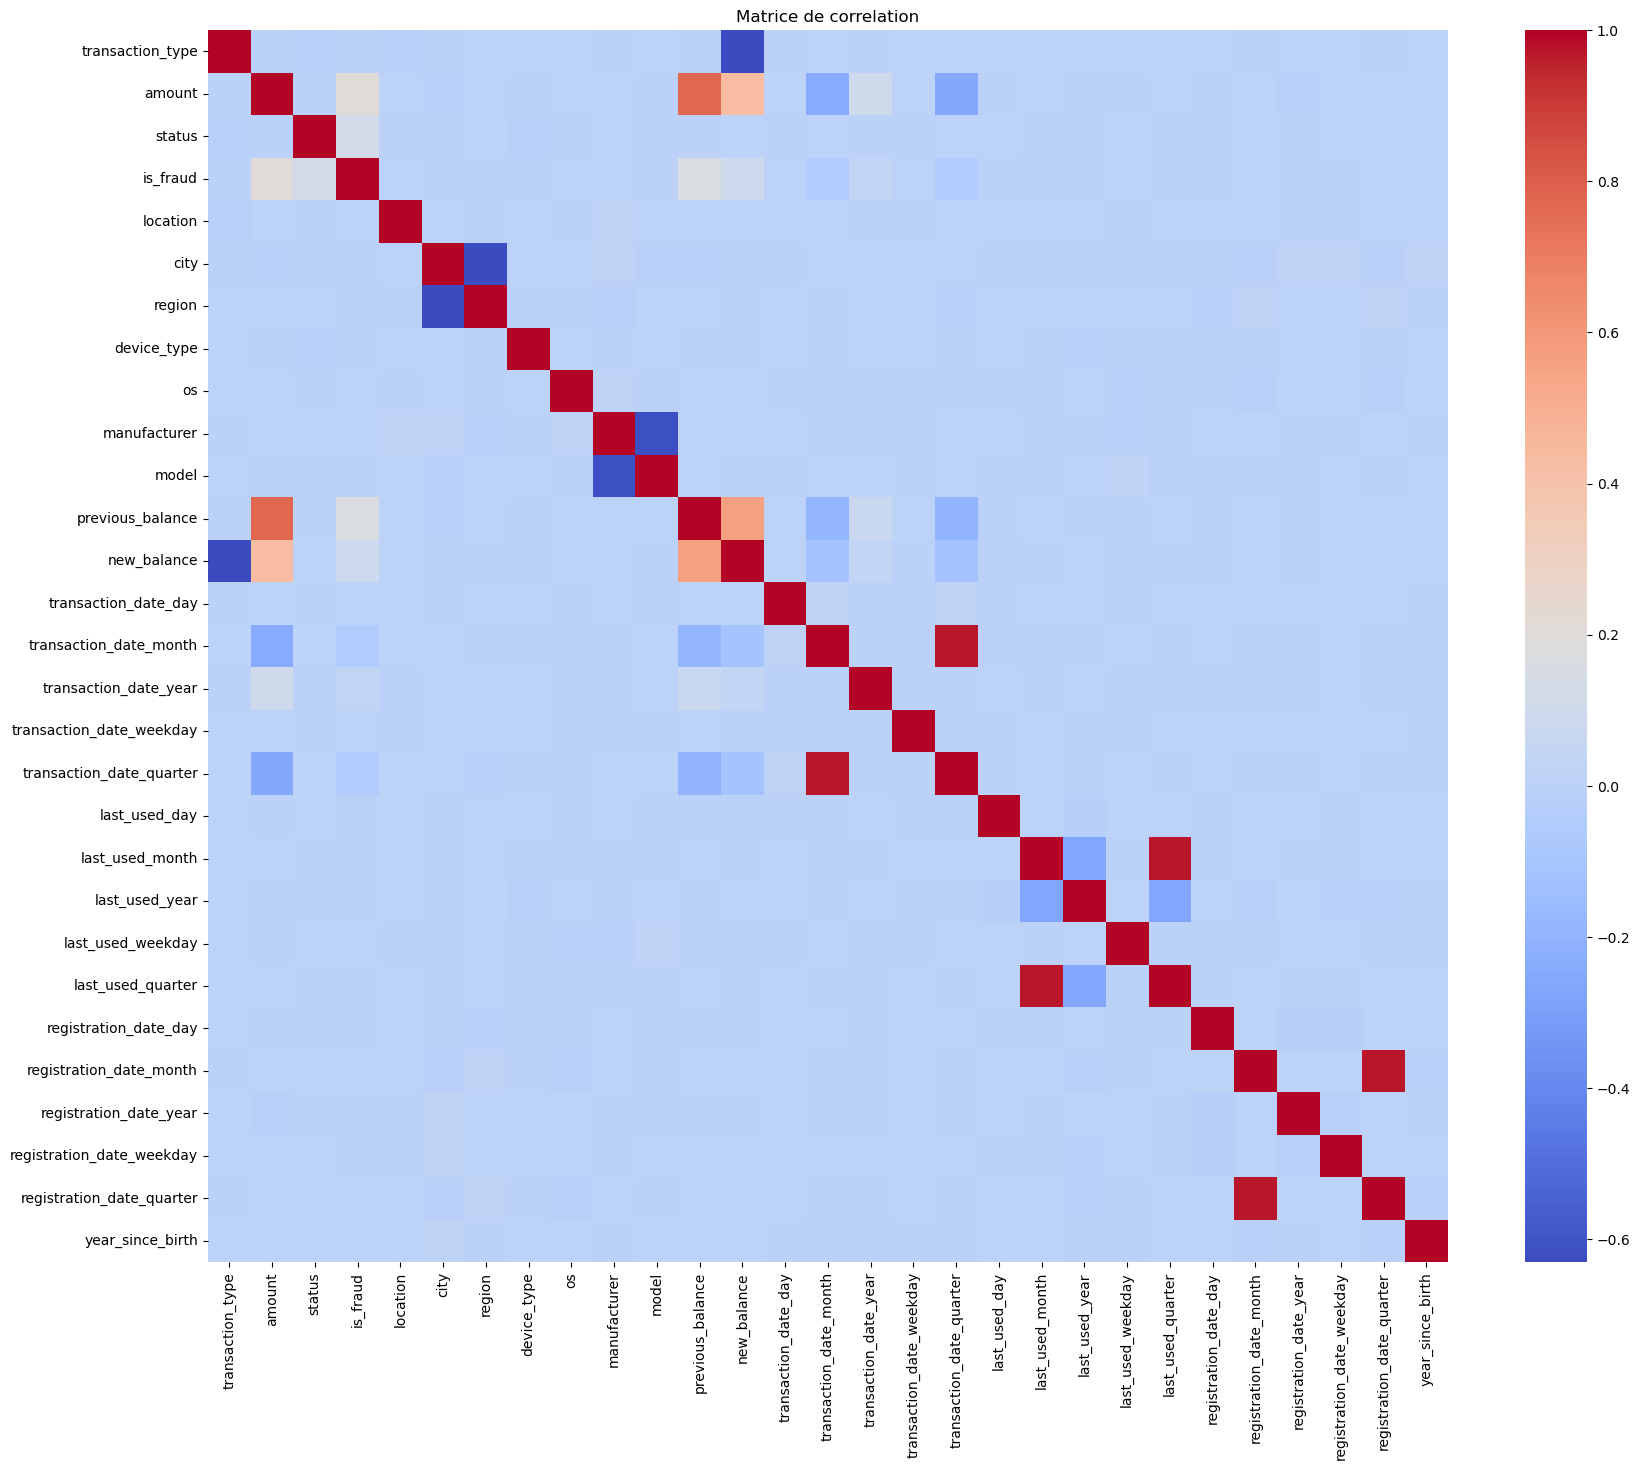

In [202]:
# Analyse de correlation
corr_matrix = data.corr()
plt.figure(figsize=(20, 16))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')
plt.title('Matrice de correlation')
plt.show()

In [203]:
# Selection des variables les plus correlees avec is_fraud
correlations_with_fraud = corr_matrix['is_fraud'].abs().sort_values(ascending=False)
print("Top 10 variables les plus corrélées avec is_fraud:")
print(correlations_with_fraud.head(6))

Top 10 variables les plus corrélées avec is_fraud:
is_fraud                    1.000000
amount                      0.209955
previous_balance            0.162420
status                      0.115933
new_balance                 0.092639
transaction_date_quarter    0.056190
Name: is_fraud, dtype: float64


L'information mutuelle est une mesure statistique qui quantifie la dépendance entre deux variables.

ici, Calcule l'information mutuelle entre chaque variable explicative et la variable cible. 

In [204]:
# Information mutuelle
X = data.drop(columns=['is_fraud']) #Contient les variables explicatives (indépendantes)
y = data['is_fraud'] #Contient la variable cible (dépendante)
mi_scores = mutual_info_regression(X, y)
mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
mi_scores = mi_scores.sort_values(ascending=False)
print("\nTop 10 variables selon l'information mutuelle:")
print(mi_scores.head(5))


Top 10 variables selon l'information mutuelle:
amount                       0.031331
previous_balance             0.013814
new_balance                  0.008821
transaction_date_quarter     0.006423
registration_date_quarter    0.004061
Name: MI Scores, dtype: float64


In [205]:
# Sélection finale des variables importantes
important_features = list(set(list(correlations_with_fraud.head(16).index) + list(mi_scores.head(16).index)))
important_features = [f for f in important_features if f != 'is_fraud']
print("\nVariables importantes sélectionnées:")
print(important_features)


Variables importantes sélectionnées:
['last_used_day', 'last_used_quarter', 'model', 'transaction_date_quarter', 'manufacturer', 'status', 'city', 'transaction_date_day', 'transaction_type', 'location', 'registration_date_weekday', 'year_since_birth', 'transaction_date_year', 'transaction_date_month', 'amount', 'transaction_date_weekday', 'previous_balance', 'registration_date_quarter', 'registration_date_month', 'new_balance']


In [206]:
# Creation du dataset final
X_final = data[important_features]
y_final = data['is_fraud']

In [207]:
# Entrainement du modele avec Isolation Forest
model = IsolationForest(contamination=0.5, random_state=42)
y_pred = model.fit_predict(X_final)

c:\Users\ESPace-TEK\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


In [208]:
y_pred

array([-1,  1, -1, ..., -1, -1,  1])

Isolation Forest: calcule un score d'anomalie pour chaque observation du dataset. Ce score donne une mesure de la normalité de chaque observation en fonction de l'ensemble des données.

In [209]:
# evaluons la precision du modele
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Convertir les prédictions de l'Isolation Forest (-1 pour anomalie, 1 pour normal) 
# en format binaire (1 pour anomalie, 0 pour normal)
#y_pred_binary = [1 if pred == -1 else 0 for pred in y_pred]

y_pred_binary = np.where(y_pred==-1, 0, y_pred)

# Calculer et afficher les métriques de classification
print(classification_report(y_final, y_pred_binary))

# Calculer l'AUC-ROC
auc_roc = roc_auc_score(y_final, y_pred_binary)
print(f"AUC-ROC: {auc_roc}")

              precision    recall  f1-score   support

           0       0.39      0.45      0.42     43293
           1       0.53      0.46      0.49     56707

    accuracy                           0.46    100000
   macro avg       0.46      0.46      0.46    100000
weighted avg       0.47      0.46      0.46    100000

AUC-ROC: 0.45756647060852673


In [210]:
print(y_pred_binary[:20])
print(y_pred[:20])

[0 1 0 1 0 0 1 0 1 1 0 0 1 0 0 0 0 1 0 1]
[-1  1 -1  1 -1 -1  1 -1  1  1 -1 -1  1 -1 -1 -1 -1  1 -1  1]


Un AUC-ROC de 0.4549 indique que votre modèle de classification a des performances très faibles. Il ne parvient pas à discriminer efficacement les classes positives des négatives.

In [211]:
# Afficher la matrice de confusion
print("Matrice de confusion:")
print(confusion_matrix(y_final, y_pred_binary))

Matrice de confusion:
[[19563 23730]
 [30437 26270]]


In [212]:
# Affichage des résultats
print("\nNombre d'anomalies détectées:", sum(y_pred == -1))


Nombre d'anomalies détectées: 50000


### II- KMEANS : Regroupons les clients dans des cluster puis identifions ceux qui sont le plus sujets aux fraudes

1. Importation des Bibliotheques

In [213]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score
from scipy.spatial.distance import cdist
from math import pi

2.1 Analyse de la base de donnee

In [214]:
df = df3.copy()
df.drop(columns=["customer_id", "device_id", "email", "phone_number", "address", "history_id", "last_used", "model", "manufacturer", "os"], inplace=True)
df.head()

,transaction_id,transaction_type,amount,status,is_fraud,location,registration_date,date_of_birth,city,region,device_type,previous_balance,new_balance,transaction_date
0,731b17cfadce442ab756b5b110a406c2,depôt,9.385805e+06,réussie,1,Douala,2015-03-02,1981-01-07,Ayos,Centre,tablette,1.933918e+07,2.872498e+07,2020-02-12
1,96f4ac611eaa4174b39149d98e569810,depôt,3.358191e+06,réussie,0,Bafoussam,2008-01-09,1986-12-05,Bafoussam,Ouest,tablette,9.557160e+06,1.291535e+07,2022-02-03
2,1c11b97ba2994efbb6f85291e7062e00,depôt,7.307758e+06,réussie,1,Bafoussam,2015-06-06,1993-07-13,Bafoussam,Ouest,mobile,1.430163e+07,2.160939e+07,2019-11-09
3,99d146a3fbd04a38a5b83190b4ec22e3,transfert,3.127519e+06,réussie,1,Bafoussam,2011-06-27,1977-03-30,Bafoussam,Ouest,tablette,7.646344e+06,4.518825e+06,2018-07-18
4,bdab6a6430b44fadbf2f1682ccda4ae8,retrait,4.435274e+06,réussie,0,Yaoundé,2006-05-08,1950-09-29,Douala,Littoral,mobile,9.679731e+06,5.244457e+06,2019-12-29


In [215]:
df = df.set_index('transaction_id')

In [216]:
df.head()

,transaction_type,amount,status,is_fraud,location,registration_date,date_of_birth,city,region,device_type,previous_balance,new_balance,transaction_date
transaction_id,,,,,,,,,,,,,
731b17cfadce442ab756b5b110a406c2,depôt,9.385805e+06,réussie,1,Douala,2015-03-02,1981-01-07,Ayos,Centre,tablette,1.933918e+07,2.872498e+07,2020-02-12
96f4ac611eaa4174b39149d98e569810,depôt,3.358191e+06,réussie,0,Bafoussam,2008-01-09,1986-12-05,Bafoussam,Ouest,tablette,9.557160e+06,1.291535e+07,2022-02-03
1c11b97ba2994efbb6f85291e7062e00,depôt,7.307758e+06,réussie,1,Bafoussam,2015-06-06,1993-07-13,Bafoussam,Ouest,mobile,1.430163e+07,2.160939e+07,2019-11-09
99d146a3fbd04a38a5b83190b4ec22e3,transfert,3.127519e+06,réussie,1,Bafoussam,2011-06-27,1977-03-30,Bafoussam,Ouest,tablette,7.646344e+06,4.518825e+06,2018-07-18
bdab6a6430b44fadbf2f1682ccda4ae8,retrait,4.435274e+06,réussie,0,Yaoundé,2006-05-08,1950-09-29,Douala,Littoral,mobile,9.679731e+06,5.244457e+06,2019-12-29


In [217]:
df.isnull().sum()

transaction_type     0
amount               0
status               0
is_fraud             0
location             0
registration_date    0
date_of_birth        0
city                 0
region               0
device_type          0
previous_balance     0
new_balance          0
transaction_date     0
dtype: int64

In [218]:
df.describe(include='all') # all, pour dire, a la fois les variable quantitatives et les variables qualitatives

,transaction_type,amount,status,is_fraud,location,registration_date,date_of_birth,city,region,device_type,previous_balance,new_balance,transaction_date
count,100000,1.000000e+05,100000,100000.000000,100000,100000,100000,100000,100000,100000,1.000000e+05,1.000000e+05,100000
unique,3,NaN,2,NaN,102,NaN,NaN,102,22,2,NaN,NaN,NaN
top,depôt,NaN,réussie,NaN,Bamenda,NaN,NaN,Bamenda,Centre,tablette,NaN,NaN,NaN
freq,50048,NaN,89972,NaN,11350,NaN,NaN,14903,18233,50217,NaN,NaN,NaN
mean,NaN,5.587385e+06,NaN,0.567070,NaN,2011-06-27 22:30:43.200000256,1971-07-11 08:37:34.752000008,NaN,NaN,NaN,1.057399e+07,1.057244e+07,2020-12-30 17:28:32.159999744
min,NaN,1.639254e+02,NaN,0.000000,NaN,2005-01-01 00:00:00,1948-07-23 00:00:00,NaN,NaN,NaN,7.688654e+04,9.024776e+00,2018-01-01 00:00:00
25%,NaN,2.660834e+06,NaN,0.000000,NaN,2008-03-21 00:00:00,1959-11-12 00:00:00,NaN,NaN,NaN,7.279777e+06,4.493306e+06,2019-07-03 00:00:00
50%,NaN,5.309755e+06,NaN,1.000000,NaN,2011-07-01 00:00:00,1971-08-17 00:00:00,NaN,NaN,NaN,1.042128e+07,8.351001e+06,2020-12-31 00:00:00
75%,NaN,8.046252e+06,NaN,1.000000,NaN,2014-10-12 00:00:00,1983-04-26 00:00:00,NaN,NaN,NaN,1.371817e+07,1.563911e+07,2022-07-01 00:00:00
max,NaN,1.574056e+07,NaN,1.000000,NaN,2017-12-31 00:00:00,1994-07-20 00:00:00,NaN,NaN,NaN,2.505568e+07,4.037580e+07,2024-01-01 00:00:00


2.2 Description des Donnees

c:\Users\ESPace-TEK\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\ESPace-TEK\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\ESPace-TEK\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\ESPace-TEK\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to 

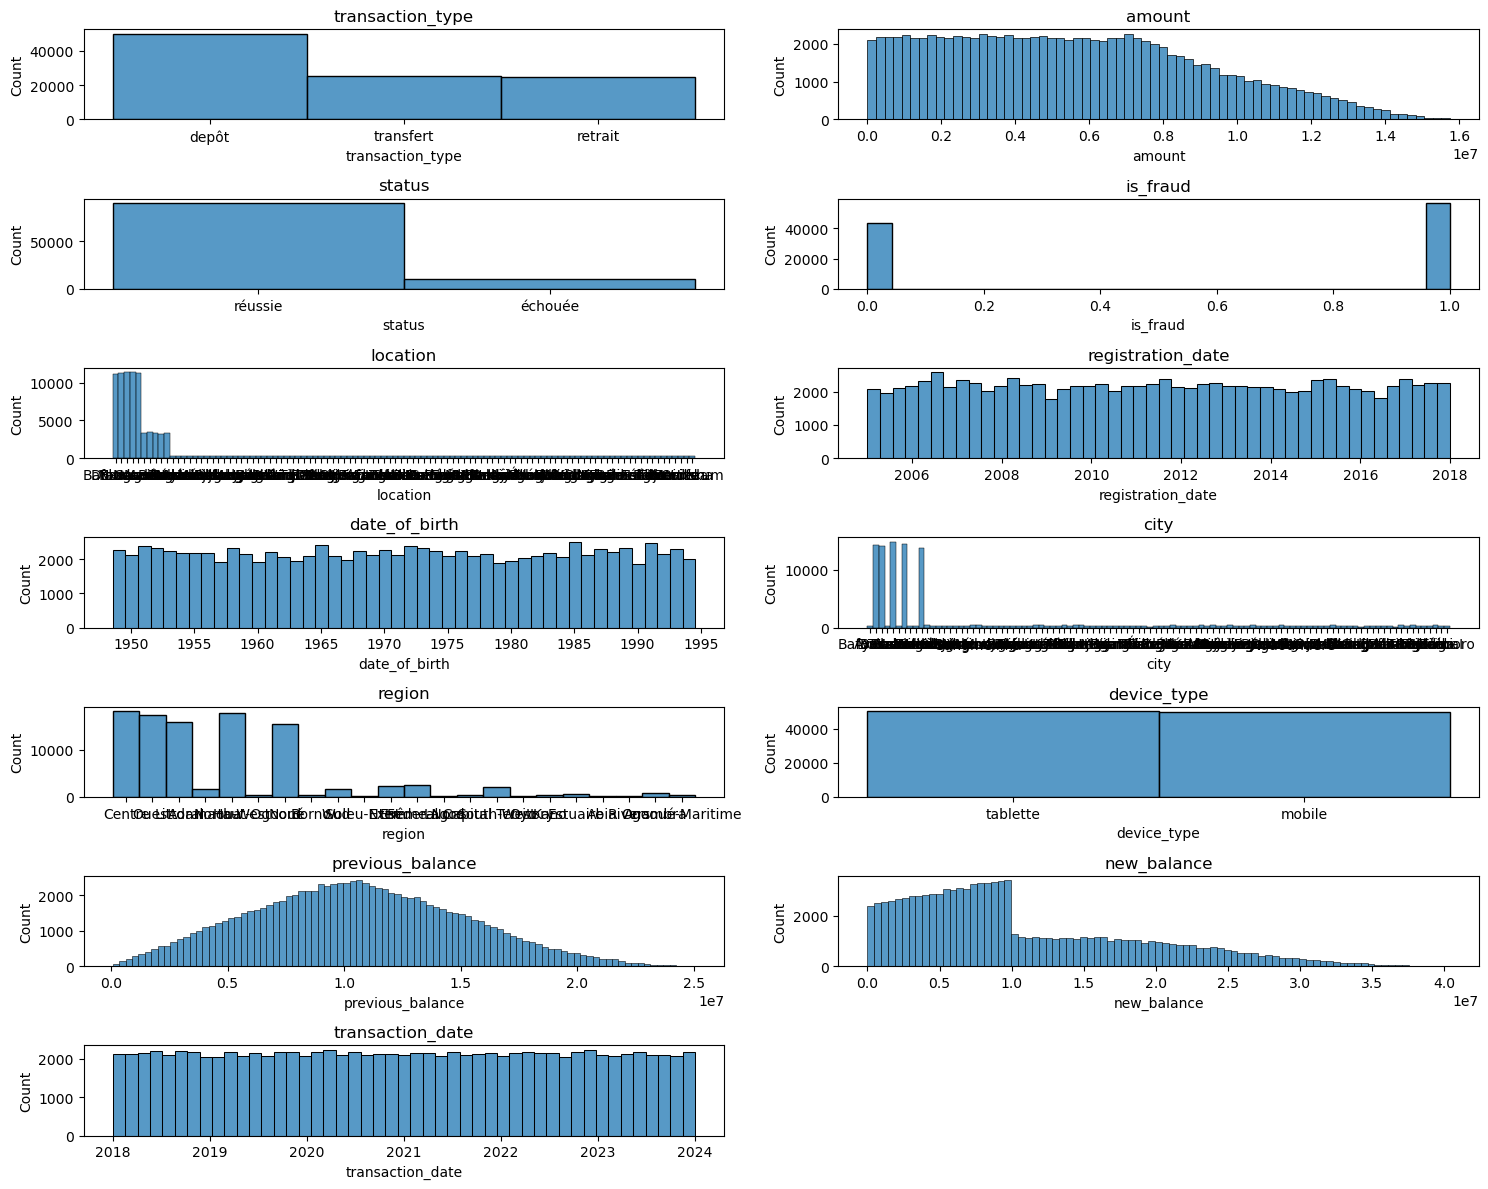

In [219]:
#Barplot pour voir, quel est la repartition, de l'ensemble des variables
 
num_cols = len(df.columns)
num_rows = num_cols // 2 if num_cols % 2 == 0 else num_cols // 2 + 1

plt.figure(figsize=(15, num_rows+5))
for i, column in enumerate(df.columns):
    plt.subplot(num_rows, 2, i+1)
    sns.histplot(df[column].dropna())
    plt.title(column)
plt.tight_layout() # pour eviter le chauvechaument des graphiques

3. Analyses Bivariees: Pour voir la relation entre les variables 2 a 2

c:\Users\ESPace-TEK\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\ESPace-TEK\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\ESPace-TEK\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\ESPace-TEK\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to 

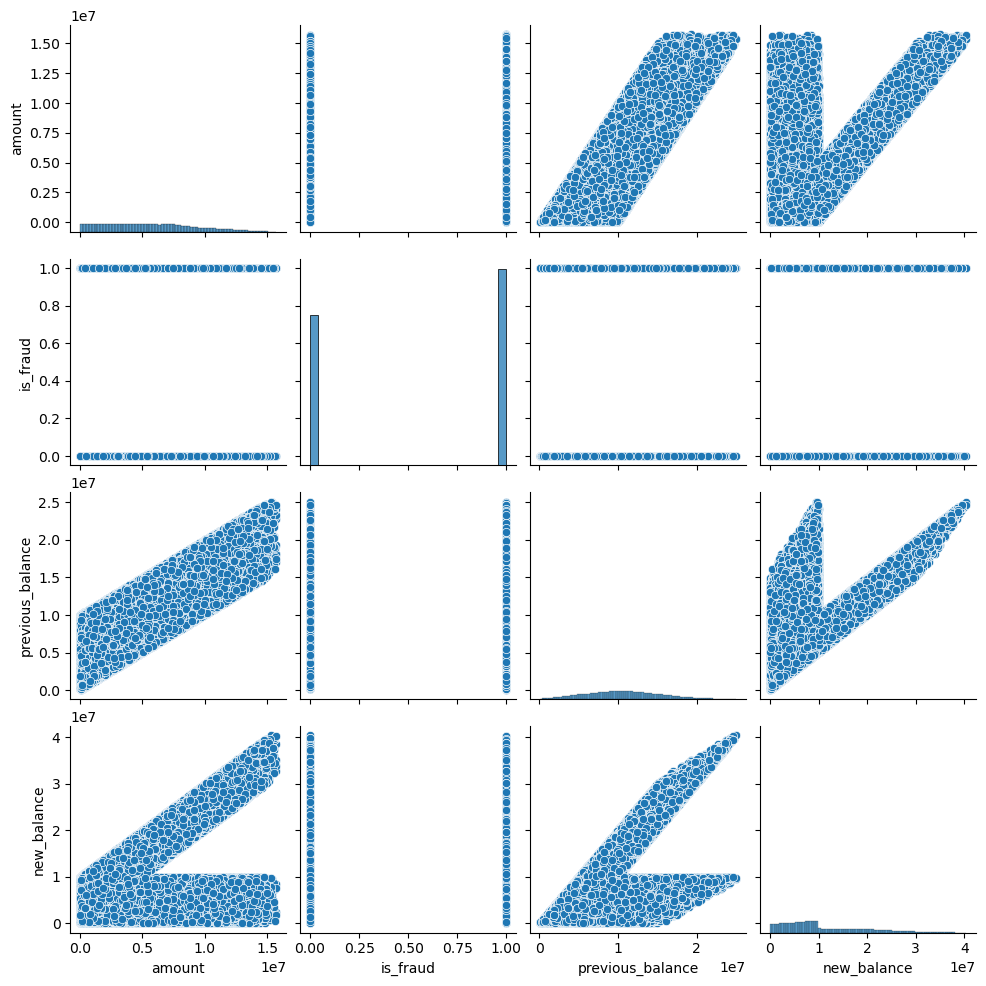

In [220]:
# Graphiques Bivaries
sns.pairplot(df)
plt.show()

In [221]:
# Selectionner uniquement les colonnes numeriques
df_numeric = df.select_dtypes(include=[np.number])

# Calculer la correlation de Spearman
correlation_spearman = df_numeric.corr(method='spearman')

# Afficher le resultat
correlation_spearman

,amount,is_fraud,previous_balance,new_balance
amount,1.000000,0.209748,0.760406,0.321385
is_fraud,0.209748,1.000000,0.162792,0.062213
previous_balance,0.760406,0.162792,1.000000,0.530265
new_balance,0.321385,0.062213,0.530265,1.000000


On Constate qu'on a pas une tres forte correlation entre les variables. En effet, elle sont en partie negatives.

ValueError: Could not interpret input 'transaction_type'

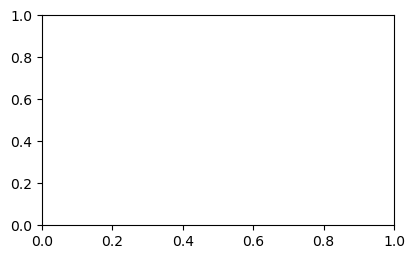

In [222]:
# Selectionner uniquement les colonnes numeriques
df_numeric = df.select_dtypes(include=[np.number])

# Ajouter le type de publication aux donnees numeriques
df_numeric['transaction_type'] = df['transaction_type']

# Creer un boxplot pour chaque colonne numerique
num_cols = len(df_numeric.columns) - 1 # -1 pour exclure 'transaction_type'

# Nombres de lignes pour les sous-graphiques
num_rows = num_cols // 2
if num_cols % 2:
    num_rows += 1
    
plt.figure(figsize=(10, 4 + num_rows))
for i, column in enumerate(df_numeric.columns.drop('transaction_type'), start=1):
    plt.subplot(num_rows, 2, i)
    sns.boxplot(x='transaction_type', y=column, dataa=df_numeric)
    plt.title(column)
    
plt.tight_layout()
plt.show()

4. Realisation de l'ACP

Normalisation

In [223]:
# Selectionner uniquement les colones numeriques
df_numeric = df.select_dtypes(include=[np.number])

# Normalisation des donnees
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_numeric)

ACP

In [224]:
# Application de l'ACP
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

In [225]:
# Calcul de la variance expliquee
var_exp = pca.explained_variance_

# Calcul de la variance expliquee cumulee
var_exp_cum = np.cumsum(pca.explained_variance_ratio_)

Identifions le nombre d'axes factoriels

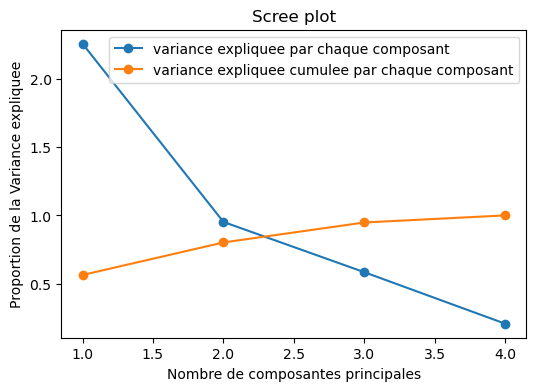

In [226]:
# Visualisation de la variance expliquee cumulee par un screen plot
plt.figure(figsize=(6, 4))
plt.plot(range(1, len(var_exp) + 1), var_exp, 'o-', label = 'variance expliquee par chaque composant')
plt.plot(range(1, len(var_exp_cum) + 1), var_exp_cum, 'o-', label = 'variance expliquee cumulee par chaque composant')
plt.title('Scree plot')
plt.xlabel('Nombre de composantes principales')
plt.ylabel('Proportion de la Variance expliquee')
plt.legend()
plt.show()

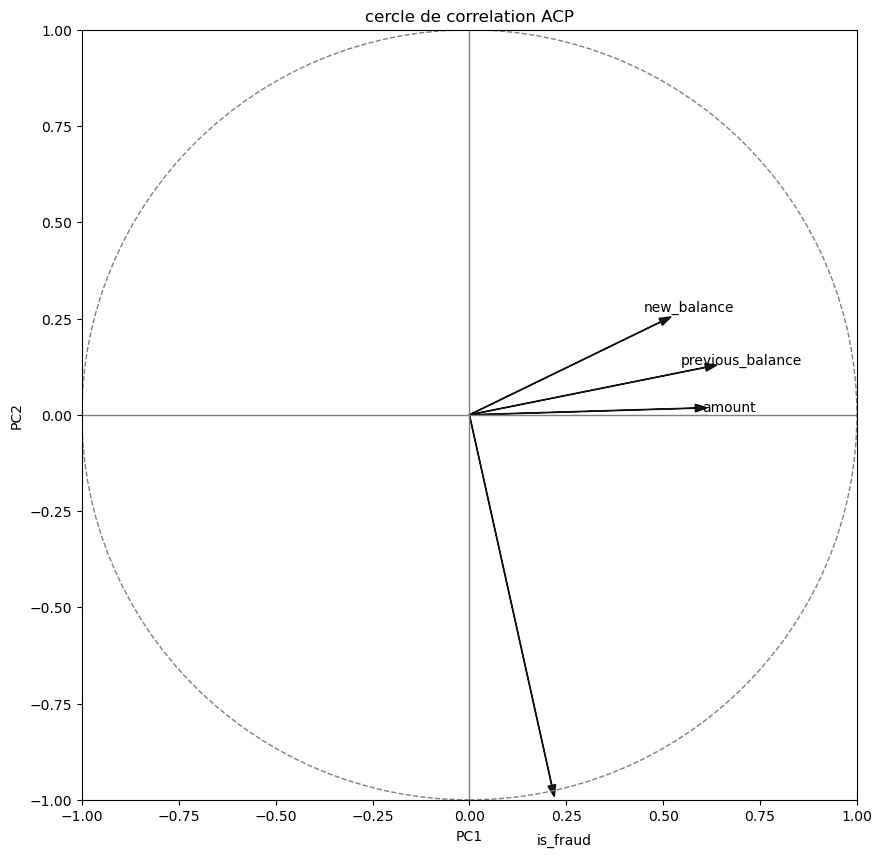

In [227]:
# Creer le cercle de correlation
coeff = np.transpose(pca.components_[0:2, :])
n = coeff.shape[0]
xs = np.array([1, 0])
ys = np.array([0, 1])

# Creer la figure
plt.figure(figsize=[10, 10])

# Fixer les vecteurs des variables
for i in range(n):
    plt.arrow(0, 0, coeff[i, 0], coeff[i, 1], color='k', alpha=0.9, head_width=0.02)
    plt.text(coeff[i, 0] * 1.15, coeff[i, 1] * 1.15, df_numeric.columns[i], color='k', ha='center', va='center')

# Fixer le cercle unitaire
circle = plt.Circle([0, 0], 1, color='gray', fill=False, linestyle='--')
plt.gca().add_artist(circle)

# Ajuster les limites et les axes
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.axhline(0, color='gray', linewidth=1)
plt.axvline(0, color='gray', linewidth=1)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('cercle de correlation ACP')

# figure
plt.show()

5. Determination des Clusters avec les KMEANS

In [235]:
# choix du nombre optimal de clusters (methode du coude et du score de silhouette)
inertias = []
silhouettes = []
K = range(2, 10)
for k in K:
    kmeansModel = KMeans(n_clusters=k, random_state=42)
    kmeansModel.fit(X_scaled)
    inertias.append(kmeansModel.inertia_)
    silhouettes.append(silhouette_score(X_scaled, kmeansModel.labels_))

c:\Users\ESPace-TEK\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\ESPace-TEK\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\ESPace-TEK\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\ESPace-TEK\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\ESPace-TEK\anaconda3\Lib\si

In [236]:
# # Détermination du nombre optimal de clusters avec la méthode du coude
# inertias = []
# K = range(1, 11)
# for k in K:
#     kmeans = KMeans(n_clusters=k, random_state=42)
#     kmeans.fit(X_scaled)
#     inertias.append(kmeans.inertia_)

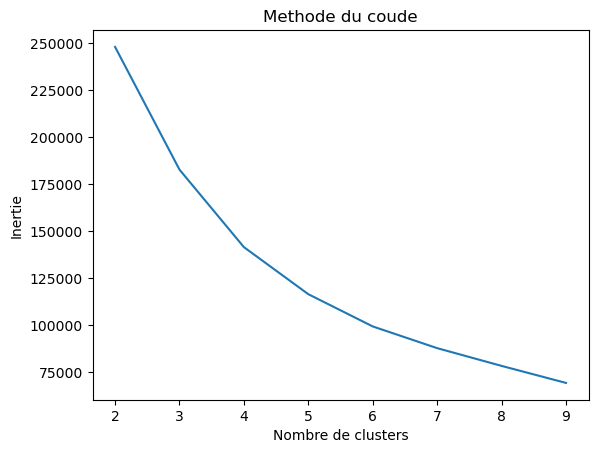

In [237]:
# tracer la courbe de l'inertie en fonction du nombre de clusters
plt.plot(range(2, 10), inertias)
plt.xlabel('Nombre de clusters')
plt.ylabel('Inertie')
plt.title('Methode du coude')
plt.show()

On constate qu'on a un petit coude entre 3 et 4

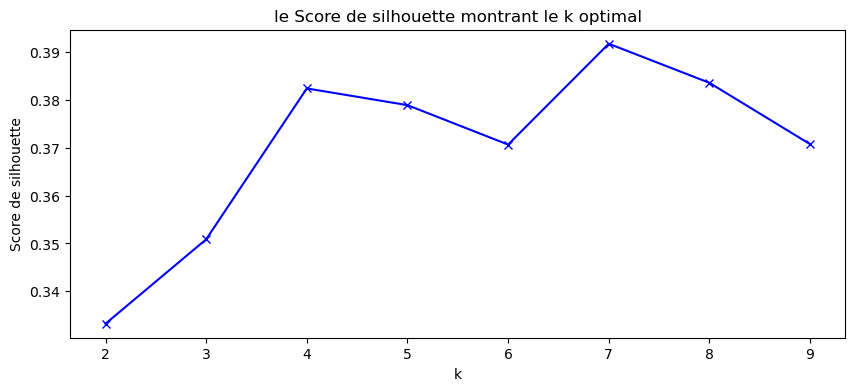

In [238]:
# graphique du score de silhouette
plt.figure(figsize=(10, 4))
plt.plot(K, silhouettes, 'bx-')
plt.xlabel('k')
plt.ylabel('Score de silhouette')
plt.title('le Score de silhouette montrant le k optimal')
plt.show()

Pour confirmer la valeur de k, on met en oeuvre le score de silhouette. Elle mesure les separation entre les cluster(groupe), donc plus il est eleve, mieux s'est!

In [239]:
# Appliquer Kmeans avec le nombre de clusters optimal trouve (supposons que c'est 4 par exemple)
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(X_scaled)

c:\Users\ESPace-TEK\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=4, random_state=42)

k est choisi par la combinaison entre "la regle du coude" et "le score de silhouette"

In [241]:
# Ajouter les labels de Clusters au Dataframe
df['cluster_label'] = kmeans.labels_

In [242]:
# Interpretation des groupes
# Afficher les statistiques des clusters
cluster_stats = df.groupby('cluster_label')[df_numeric.columns].mean()
cluster_stats
df['cluster_label'].value_counts()

cluster_label
1    34562
3    27859
2    20357
0    17222
Name: count, dtype: int64

In [243]:
cluster_stats

,amount,is_fraud,previous_balance,new_balance
cluster_label,,,,
0,9.419788e+06,0.805946,1.507747e+07,5.657685e+06
1,3.583362e+06,0.000000,8.266963e+06,7.864336e+06
2,8.942070e+06,0.735275,1.471212e+07,2.365419e+07
3,3.253135e+06,1.000000,7.628330e+06,7.411324e+06


In [ ]:
# Handle missing values (replace with an appropriate method based on your data)
df_numeric = df_numeric.fillna(method='ffill')

# Creer un Boxplot pour chaque colonne numerique 
num_cols = len(df_numeric.columns) 

# Nombre de lignes pour les sous-graphiques
num_rows = num_cols // 2
if num_cols % 2:
    num_rows += 1
    
plt.figure(figsize=(10, 4 * num_rows))
for i, column in enumerate (df_numeric.columns, start=1):
    plt.subplot(num_rows, 2, i)
    sns.boxplot(y =column, showmeans=True, dataa=df)
    plt.title(column)

plt.tight_layout()
plt.show()

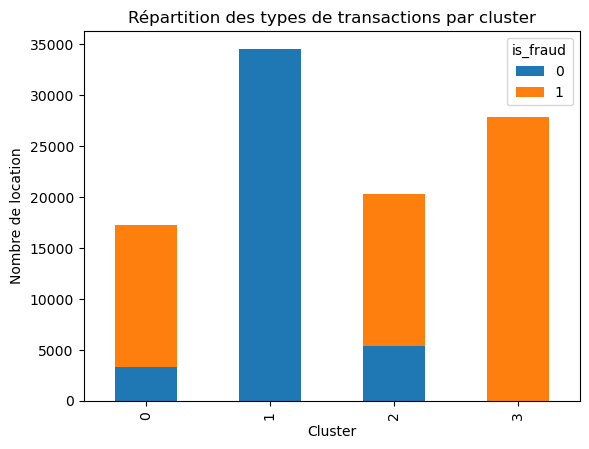

In [259]:
# Créer une table de contingence entre cluster_label et is_fraud 
contingency_table = pd.crosstab(df['cluster_label'], df['is_fraud'])

#Tracer le barplot
contingency_table.plot(kind='bar', stacked=True)

#Ajouter des étiquettes et des titres
plt.xlabel('Cluster')
plt.ylabel('Nombre de location')
plt.title('Répartition des types de transactions par cluster')

# Afficher la légende
plt.legend(title='is_fraud')

# Afficher le graphique
plt.show()


In [ ]:
import seaborn as sns

# Visualisations des groupes 
sns.scatterplot(dataa=df, x='amount', y='previous_balance', hue='cluster_label', palette='Set1')
plt.title('Cluster K-means')
plt.show()

6. Determination des clients les plus sujet aux fraudes

In [260]:
# Utilisation des composants principales pour le clustering K-means
# attribuons chaque observation à un cluster.
df['cluster'] = kmeans.fit_predict(X_pca)

c:\Users\ESPace-TEK\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


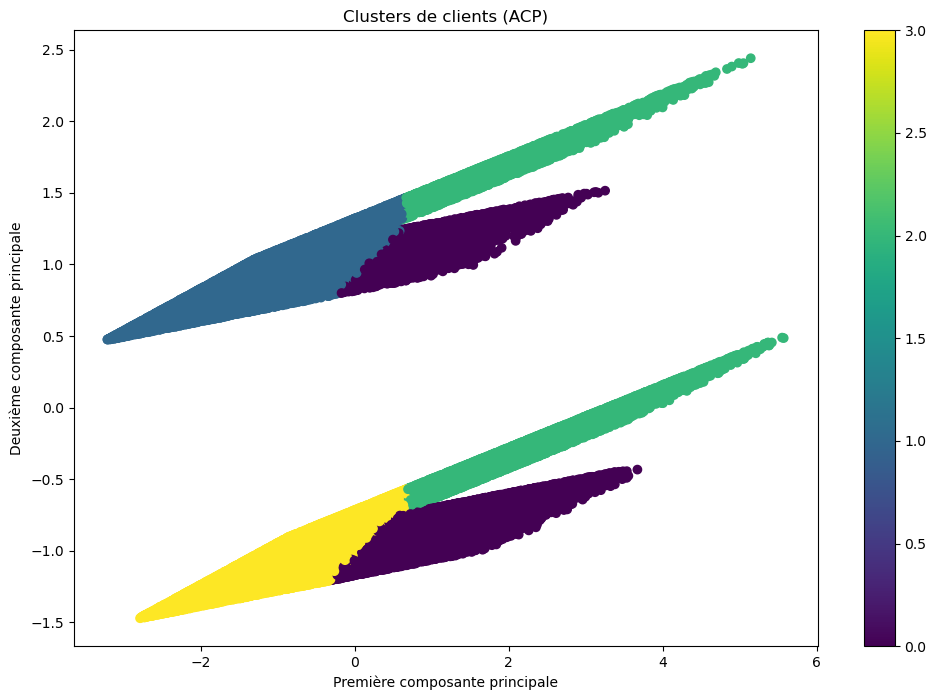

In [261]:
# Visualisation des deux premières composantes principales
plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df['cluster'], cmap='viridis')
plt.colorbar(scatter)
plt.xlabel('Première composante principale')
plt.ylabel('Deuxième composante principale')
plt.title('Clusters de clients (ACP)')
plt.show()

In [178]:
# 1ere methode
# Analyse des clusters
for i in range(4):
    cluster_df = df[df['cluster'] == i]
    print(f"\nCluster {i}:")
    print(f"Nombre de clients : {len(cluster_df)}")
    print(f"Taux de fraude : {cluster_df['is_fraud'].mean():.2%}")


Cluster 0:
Nombre de clients : 17222
Taux de fraude : 80.59%

Cluster 1:
Nombre de clients : 34562
Taux de fraude : 0.00%

Cluster 2:
Nombre de clients : 20357
Taux de fraude : 73.53%

Cluster 3:
Nombre de clients : 27859
Taux de fraude : 100.00%


OU

In [182]:
# 2e methode
# Analyse des clusters
print("\nDistribution des clients par cluster:")
print(df['cluster'].value_counts())

# Identification des clusters les plus sujets aux fraudes
fraud_by_cluster = df.groupby('cluster')['is_fraud'].mean().round(2) * 100
print("\nTaux de fraude par cluster:")
print(fraud_by_cluster)

# OU

# # Identification des clusters les plus à risque ou les plus sujets aux fraudes
# cluster_fraud_rates = data.groupby('cluster')['is_fraud'].mean().sort_values(ascending=False)
# print("\nTaux de fraude par cluster :")
# print(cluster_fraud_rates)


Distribution des clients par cluster:
cluster
1    34562
3    27859
2    20357
0    17222
Name: count, dtype: int64

Taux de fraude par cluster:
cluster
0     81.0
1      0.0
2     74.0
3    100.0
Name: is_fraud, dtype: float64


In [262]:
# 3e methode 
# Analyse des clusters
for cluster_label in range(4):
    cluster_data = df[df['cluster_label'] == cluster_label]
    fraud_ratio = cluster_data['is_fraud'].mean()
    print(f"Cluster {cluster_label}: Taux de fraude = {fraud_ratio:.2%}")

Cluster 0: Taux de fraude = 80.59%
Cluster 1: Taux de fraude = 0.00%
Cluster 2: Taux de fraude = 73.53%
Cluster 3: Taux de fraude = 100.00%


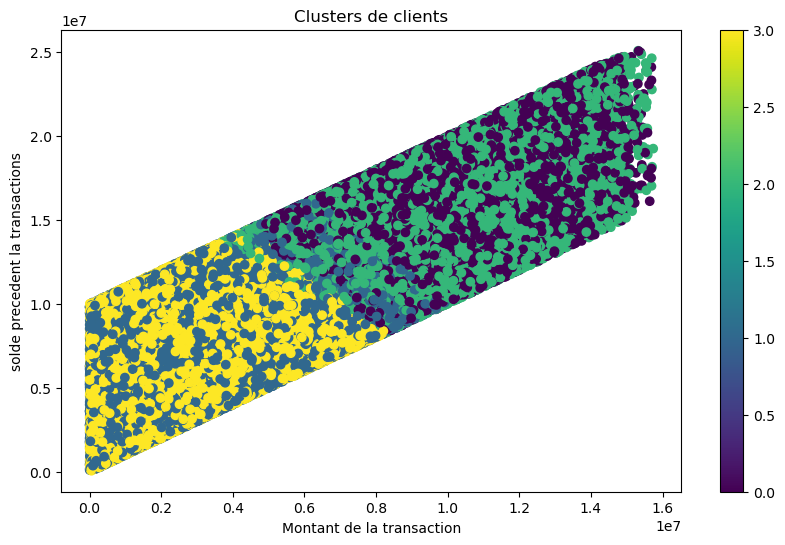

In [263]:
# Visualisation des clusters (exemple avec deux caractéristiques)
plt.figure(figsize=(10, 6))
scatter = plt.scatter(df['amount'], df['previous_balance'], c=df['cluster'], cmap='viridis')
plt.colorbar(scatter)
plt.xlabel('Montant de la transaction')
plt.ylabel('solde precedent la transactions')
plt.title('Clusters de clients')
plt.show()

Conclusion: Analyse des résultats:

Les résultats de votre clustering K-means sur les transactions mobile money sont clairs et offrent des insights intéressants :

- Cluster 0 et 2: Ces deux clusters présentent des taux de fraude très élevés, respectivement 80.59% et 73.53%. Ces clients sont très susceptibles d'être impliqués dans des activités frauduleuses.
- Cluster 1: Ce cluster ne présente aucun cas de fraude. Il s'agit probablement de clients "idéaux" qui effectuent des transactions normales et légitimes.
- Cluster 3: Ce cluster est composé uniquement de transactions frauduleuses. Il pourrait représenter un type de fraude très spécifique ou ciblée.